# Cuaderno 02: Entrenamiento de la Vía Auditiva (Fonema -> Clasificación)

**Objetivo:** Entrenar un modelo que pueda identificar un fonema a partir de su secuencia completa de características de audio.

**Flujo de Trabajo:**
1.  **Instalación de Librerías**: Instalar `transformers`, `torch`, `torchaudio` y `librosa`.
2.  **Configuración**: Definir rutas y el modelo `wav2vec2` a utilizar.
3.  **Carga de Datos**: Cargar los archivos `.wav` de un idioma.
4.  **Extracción de Embeddings**: Procesar cada audio con `wav2vec2` para extraer la **secuencia completa** de embeddings.
5.  **Preparación del Dataset**: Crear `DataLoaders` que manejen secuencias de longitud variable mediante **padding**.
6.  **Definición y Entrenamiento del Modelo**: Construir y entrenar una **CNN 1D con Global Pooling** para clasificar las secuencias.
7.  **Evaluación y Guardado**: Generar una matriz de confusión, graficar métricas y guardar el modelo final.

## Paso 1: Instalación de Librerías

Instalamos las librerías de `transformers` de Hugging Face (para `wav2vec2`), `pytorch` (para la red neuronal), y `librosa` (una potente herramienta para el análisis de audio).

In [ ]:
%pip install transformers torch torchaudio librosa

## Paso 2: Configuración y Rutas

Importamos las librerías necesarias y definimos las rutas a los datos que generamos en el cuaderno anterior. También especificamos el modelo `wav2vec2` que usaremos. `xlsr-53` es un modelo multilingüe excelente.

In [22]:
import torch
import torchaudio
import librosa
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from pathlib import Path
import numpy as np
import pandas as pd

# --- Selección de Idioma ---
LANGUAGE = 'en'

# --- Arquitectura del Modelo (para nombrar archivos) ---
MODEL_ARCHITECTURE = "cnn1d_v1"

# --- Rutas de Entrada ---
project_root = Path.cwd().parent
audio_dir = project_root / f"data/02_processed/phoneme_audio/{LANGUAGE}"

# --- Rutas de Salida ---
embedding_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{LANGUAGE}"
embedding_dir.mkdir(parents=True, exist_ok=True)
model_dir = project_root / "results/trained_models"
model_dir.mkdir(parents=True, exist_ok=True)
figure_dir = project_root / "results/figures"
figure_dir.mkdir(parents=True, exist_ok=True)
results_dir = project_root / "results/tables"
results_dir.mkdir(parents=True, exist_ok=True)

# --- Nombres de Archivo de Salida Descriptivos ---
# Figuras de Análisis de Embeddings
cosine_similarity_path = figure_dir / f"{LANGUAGE}_auditory_embedding_cosine_similarity.png"
tsne_plot_path = figure_dir / f"{LANGUAGE}_auditory_embedding_tsne_plot.png"

# Figuras y Resultados del Entrenamiento del Modelo
learning_curves_path = figure_dir / f"{LANGUAGE}_auditory_{MODEL_ARCHITECTURE}_learning_curves.png"
confusion_matrix_path = figure_dir / f"{LANGUAGE}_auditory_{MODEL_ARCHITECTURE}_confusion_matrix.png"
classification_report_path = results_dir / f"{LANGUAGE}_auditory_{MODEL_ARCHITECTURE}_classification_report.csv"
model_path = model_dir / f"{LANGUAGE}_auditory_{MODEL_ARCHITECTURE}.pth"

# --- Configuración del Modelo ---
WAV2VEC2_MODEL_NAME = "facebook/wav2vec2-large-xlsr-53"
TARGET_SAMPLE_RATE = 16000

## Paso 3: Cargar los Archivos de Audio

Creamos una lista de todos nuestros archivos `.wav`, cargando la onda de audio y su etiqueta de fonema correspondiente. Nos aseguramos de que todos los audios tengan la frecuencia de muestreo correcta (16kHz).

In [23]:
def load_audio_data(directory, sample_rate):
    audio_data = []
    filepaths = sorted(list(directory.glob("*.wav")))
    for path in filepaths:
        try:
            waveform, sr = librosa.load(path, sr=sample_rate)
            label = path.stem
            audio_data.append({"path": path, "waveform": waveform, "label": label})
        except Exception as e:
            print(f"Error cargando el archivo {path}: {e}")
    return audio_data

phoneme_data = load_audio_data(audio_dir, TARGET_SAMPLE_RATE)
print(f"Se cargaron {len(phoneme_data)} archivos de audio.")

Se cargaron 33 archivos de audio.


## Paso 4: Extracción de Embeddings con `wav2vec2`

Este es el paso central de la vía auditiva. Usaremos un modelo `wav2vec2` pre-entrenado para procesar cada audio.

**¿Cómo funciona?**
1.  **Cargar el Modelo**: Descargamos el modelo y su "procesador" desde Hugging Face. El procesador prepara el audio para que el modelo pueda entenderlo.
2.  **Procesar el Audio**: Pasamos la onda de audio por el modelo.
3.  **Extraer los Embeddings**: El modelo devuelve las salidas de sus capas internas (estados ocultos). Tomaremos la salida de la última capa y la promediaremos en el tiempo para obtener un único vector que represente a todo el fonema.
4.  **Guardar los Resultados**: Guardamos cada embedding en un archivo `.npy` para no tener que repetir este proceso, que es computacionalmente intensivo.

In [24]:
# Cargar el extractor de características y el modelo
print(f"Cargando el modelo '{WAV2VEC2_MODEL_NAME}'...")
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(WAV2VEC2_MODEL_NAME)
model = Wav2Vec2Model.from_pretrained(WAV2VEC2_MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Modelo cargado en: {device}")

# --- Proceso de Extracción ---
print("\n--- Iniciando extracción de embeddings secuenciales ---")
for i, data_item in enumerate(phoneme_data):
    label = data_item['label']
    embedding_path = embedding_dir / f"{label}.npy"
    
    if embedding_path.exists():
        print(f"({i+1}/{len(phoneme_data)}) El embedding para '{label}' ya existe. Omitiendo.")
        continue
        
    try:
        waveform = data_item['waveform']
        inputs = feature_extractor(waveform, sampling_rate=TARGET_SAMPLE_RATE, return_tensors="pt", padding=True)
        input_values = inputs.input_values.to(device)
        
        with torch.no_grad():
            outputs = model(input_values)
        
        # Extraemos la secuencia completa del último estado oculto
        sequence_embedding = outputs.last_hidden_state.squeeze(0)
        embedding_np = sequence_embedding.cpu().numpy()
        np.save(embedding_path, embedding_np)
        print(f"({i+1}/{len(phoneme_data)}) Embedding para '{label}' guardado con forma {embedding_np.shape}.")
    except Exception as e:
        print(f"Error al procesar '{label}': {e}")

Cargando el modelo 'facebook/wav2vec2-large-xlsr-53'...
Modelo cargado en: cuda

--- Iniciando extracción de embeddings secuenciales ---
(1/33) El embedding para 'a' ya existe. Omitiendo.
(2/33) El embedding para 'ay' ya existe. Omitiendo.
(3/33) El embedding para 'b' ya existe. Omitiendo.
(4/33) El embedding para 'c' ya existe. Omitiendo.
(5/33) El embedding para 'ch' ya existe. Omitiendo.
(6/33) El embedding para 'd' ya existe. Omitiendo.
(7/33) El embedding para 'e' ya existe. Omitiendo.
(8/33) El embedding para 'ee' ya existe. Omitiendo.
(9/33) El embedding para 'f' ya existe. Omitiendo.
(10/33) El embedding para 'g' ya existe. Omitiendo.
(11/33) El embedding para 'h' ya existe. Omitiendo.
(12/33) El embedding para 'i' ya existe. Omitiendo.
(13/33) El embedding para 'igh' ya existe. Omitiendo.
(14/33) El embedding para 'j' ya existe. Omitiendo.
(15/33) El embedding para 'k' ya existe. Omitiendo.
(16/33) El embedding para 'l' ya existe. Omitiendo.
(17/33) El embedding para 'm' ya ex

### Paso 5: Análisis y Visualización de Embeddings

Antes de entrenar, analizamos los embeddings para entender su estructura. Esto nos da una línea base de cuán separables son los fonemas.

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar todos los embeddings guardados
labels = [item['label'] for item in phoneme_data]
embedding_sequences = [torch.tensor(np.load(embedding_dir / f"{label}.npy"), dtype=torch.float32) for label in labels]
# Para este análisis, promediamos los embeddings para tener un vector por fonema
embedding_matrix_avg = np.array([seq.mean(dim=0).numpy() for seq in embedding_sequences])

print(f"Se cargaron {len(labels)} embeddings para el idioma '{LANGUAGE}'.")

Se cargaron 33 embeddings para el idioma 'en'.


### 5.1 Matriz de Similitud Coseno

Visualizamos la similitud entre los vectores promedio de cada fonema.

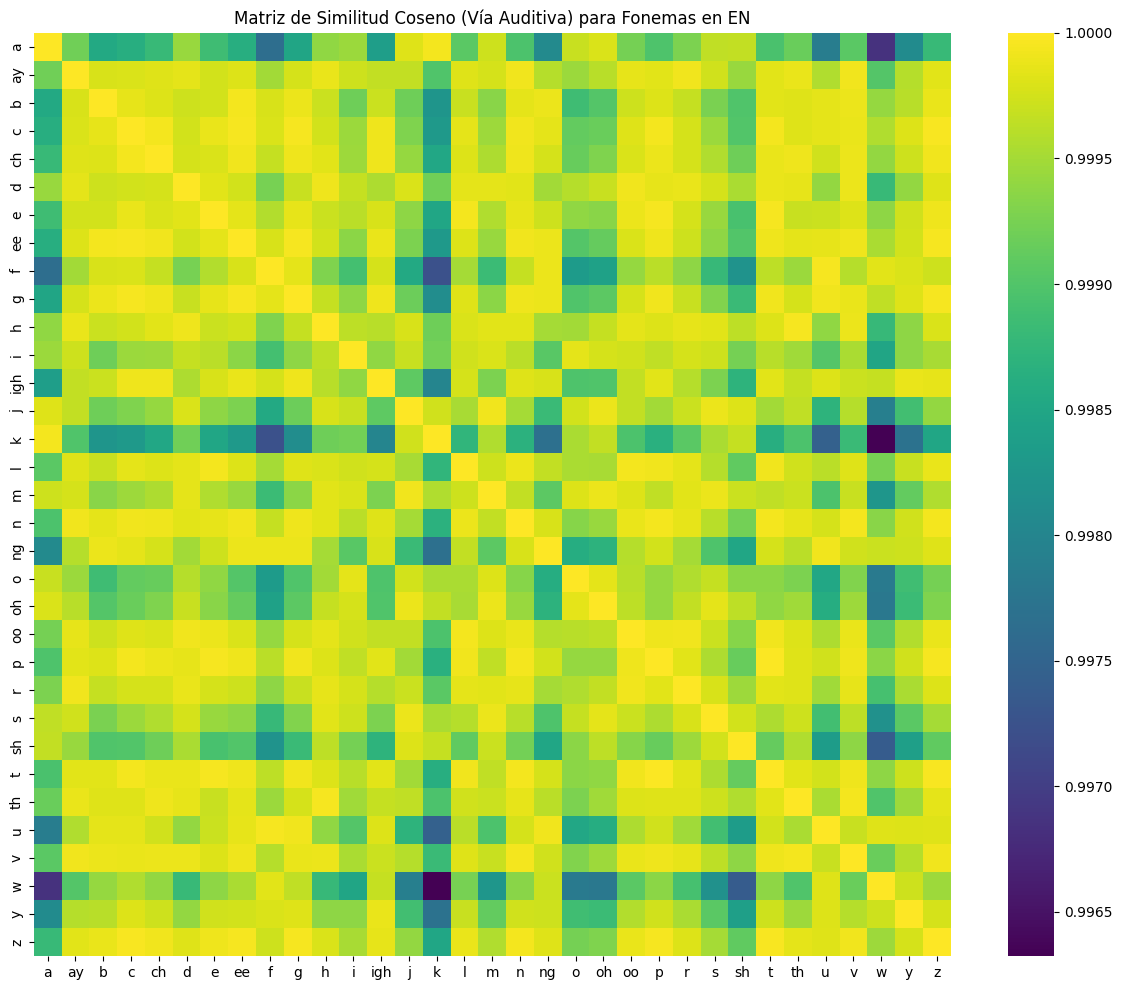

Heatmap de similitud guardado en: /home/daniel/Proyectos/phonological-awareness/results/figures/en_auditory_embedding_cosine_similarity.png


In [26]:
similarity_matrix = cosine_similarity(embedding_matrix_avg)
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix, xticklabels=labels, yticklabels=labels, cmap='viridis')
plt.title(f'Matriz de Similitud Coseno (Vía Auditiva) para Fonemas en {LANGUAGE.upper()}')
plt.tight_layout()
plt.savefig(cosine_similarity_path) # Guardar la figura
plt.show()
print(f"Heatmap de similitud guardado en: {cosine_similarity_path}")

### 5.2 Proyección 2D con t-SNE

Proyectamos los embeddings a 2D para visualizar si forman clusters.

Calculando proyección t-SNE...


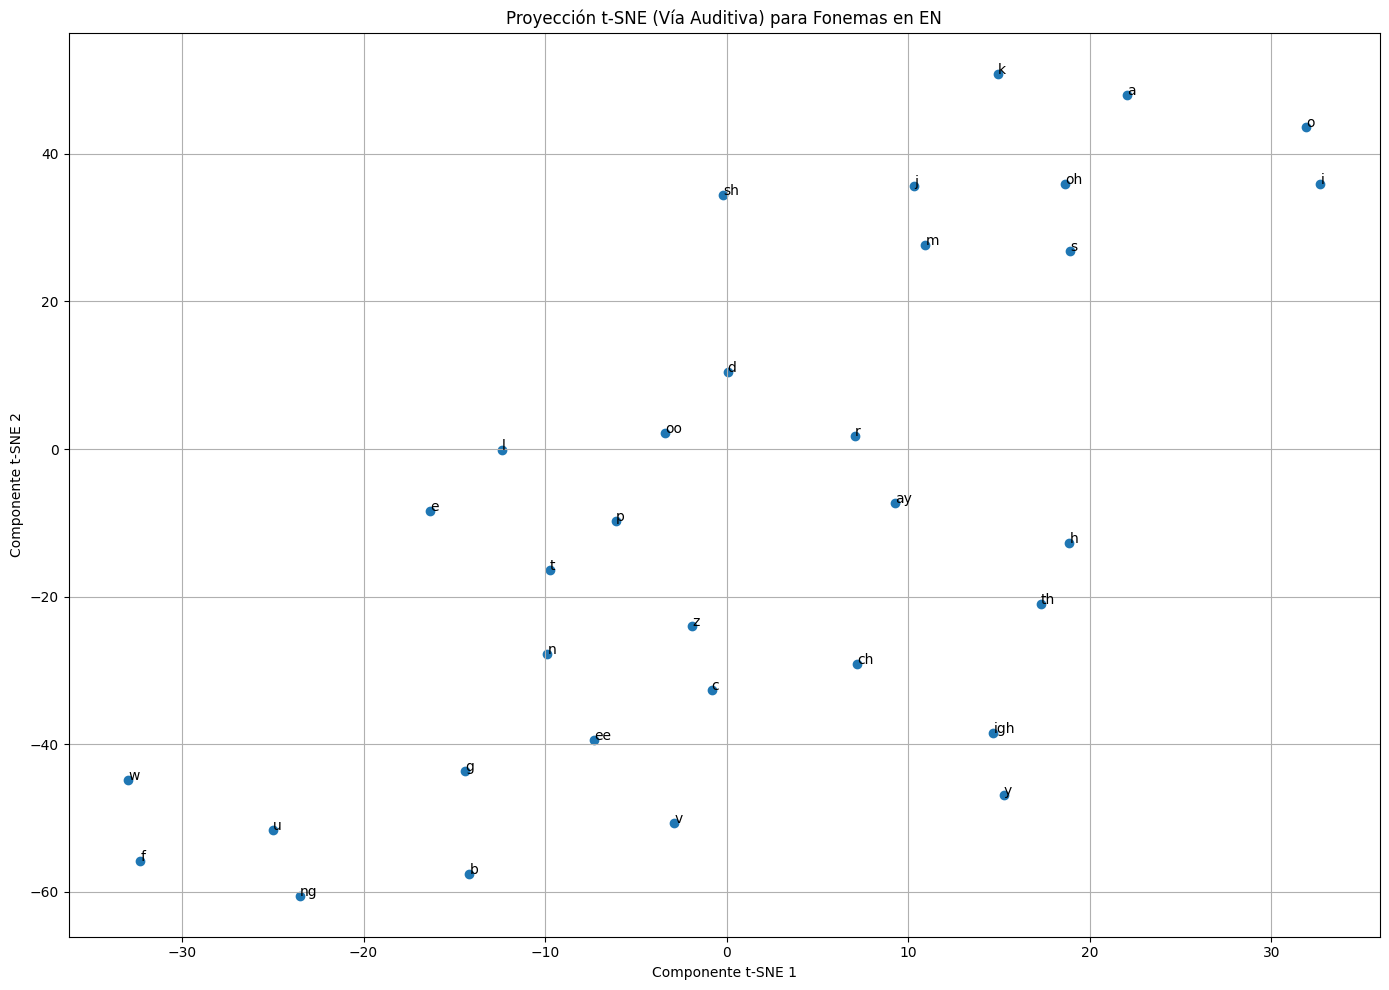

Gráfico t-SNE guardado en: /home/daniel/Proyectos/phonological-awareness/results/figures/en_auditory_embedding_tsne_plot.png


In [27]:
print("Calculando proyección t-SNE...")
tsne = TSNE(n_components=2, perplexity=10, random_state=42, init='pca', learning_rate='auto')
embeddings_2d = tsne.fit_transform(embedding_matrix_avg)

plt.figure(figsize=(14, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for i, label in enumerate(labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.title(f'Proyección t-SNE (Vía Auditiva) para Fonemas en {LANGUAGE.upper()}')
plt.xlabel('Componente t-SNE 1'); plt.ylabel('Componente t-SNE 2'); plt.grid(True)
plt.tight_layout()
plt.savefig(tsne_plot_path) # Guardar la figura
plt.show()
print(f"Gráfico t-SNE guardado en: {tsne_plot_path}")

## Paso 6: Preparación de Datos para el Entrenamiento

Ahora preparamos el `DataLoader` usando las **secuencias completas** de embeddings.

In [28]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# --- Cargar embeddings guardados ---
labels = [item['label'] for item in phoneme_data]
embedding_sequences = [torch.tensor(np.load(embedding_dir / f"{label}.npy"), dtype=torch.float32) for label in labels]

# --- Mapeo de etiquetas y Dataset ---
label_to_int = {label: i for i, label in enumerate(labels)}
int_to_label = {i: label for label, i in label_to_int.items()}
num_classes = len(labels)
labels_tensor = torch.tensor([label_to_int[label] for label in labels], dtype=torch.long)

class PhonemeSequenceDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

full_dataset = PhonemeSequenceDataset(embedding_sequences, labels_tensor)

# --- Función de "Collate" para manejar secuencias de longitud variable ---
def collate_fn(batch):
    embeddings = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    labels = torch.stack(labels)
    # batch_first=True nos da una salida de (Batch, Longitud, Features)
    padded_embeddings = pad_sequence(embeddings, batch_first=True, padding_value=0.0)
    return padded_embeddings, labels

# --- DataLoader ---
BATCH_SIZE = 8
data_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
print(f"Dataset preparado con {len(full_dataset)} secuencias.")

Dataset preparado con 33 secuencias.


## Paso 7: Definición del Modelo y Entrenamiento

Entrenamos la CNN 1D con la arquitectura secuencial.

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class PhonemeCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(PhonemeCNN, self).__init__()
        # La entrada es (Batch, Longitud, Features). La transponemos a (Batch, Features, Longitud)
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        # Global Average Pooling a lo largo de la dimensión de tiempo
        x = F.adaptive_avg_pool1d(x, 1).squeeze(-1)
        x = self.fc(x)
        return x

# --- Bucle de Entrenamiento ---
LEARNING_RATE = 0.001
EPOCHS = 1000
input_size = embedding_sequences[0].shape[1] # Dimensión de features

model = PhonemeCNN(input_size=input_size, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
history = {'train_loss': [], 'train_accuracy': []}

print("\n--- Iniciando entrenamiento con la nueva arquitectura de CNN ---")
for epoch in range(EPOCHS):
    model.train()
    running_loss, correct_preds, total_samples = 0.0, 0, 0
    for batch_embeddings, batch_labels in data_loader:
        batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_embeddings)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += batch_labels.size(0)
        correct_preds += (predicted == batch_labels).sum().item()
    
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = 100 * correct_preds / total_samples
    history['train_loss'].append(epoch_loss)
    history['train_accuracy'].append(epoch_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
print("--- Entrenamiento finalizado. ---")


--- Iniciando entrenamiento con la nueva arquitectura de CNN ---
Epoch [10/300], Loss: 3.3262, Accuracy: 6.06%
Epoch [20/300], Loss: 3.2544, Accuracy: 6.06%
Epoch [30/300], Loss: 2.9581, Accuracy: 21.21%
Epoch [40/300], Loss: 2.9428, Accuracy: 24.24%
Epoch [50/300], Loss: 2.8906, Accuracy: 30.30%
Epoch [60/300], Loss: 2.5631, Accuracy: 39.39%
Epoch [70/300], Loss: 2.5615, Accuracy: 24.24%
Epoch [80/300], Loss: 2.3778, Accuracy: 45.45%
Epoch [90/300], Loss: 2.4066, Accuracy: 36.36%
Epoch [100/300], Loss: 2.0917, Accuracy: 63.64%
Epoch [110/300], Loss: 1.7796, Accuracy: 72.73%
Epoch [120/300], Loss: 1.8817, Accuracy: 57.58%
Epoch [130/300], Loss: 1.7169, Accuracy: 78.79%
Epoch [140/300], Loss: 1.9284, Accuracy: 72.73%
Epoch [150/300], Loss: 1.6168, Accuracy: 78.79%
Epoch [160/300], Loss: 1.4154, Accuracy: 84.85%
Epoch [170/300], Loss: 1.3278, Accuracy: 75.76%
Epoch [180/300], Loss: 1.2962, Accuracy: 93.94%
Epoch [190/300], Loss: 1.0192, Accuracy: 93.94%
Epoch [200/300], Loss: 1.1827, Ac

## Paso 8: Evaluación Final, Visualización y Guardado de Resultados

Evaluamos el modelo, generamos los resultados visuales y numéricos, y los guardamos en archivos con nombres descriptivos.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

model.eval()
all_labels, all_preds = [], []
with torch.no_grad():
    for batch_embeddings, batch_labels in data_loader:
        batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
        outputs = model(batch_embeddings)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(batch_labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# --- 1. Guardar Informe de Clasificación como CSV ---
print("--- Informe de Clasificación ---")
class_names = [int_to_label[i] for i in range(num_classes)]
# Generar el reporte como un diccionario
report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
# Convertir a DataFrame de Pandas
report_df = pd.DataFrame(report_dict).transpose()
# Guardar como CSV
report_df.to_csv(classification_report_path)
print(f"Informe de clasificación guardado en: {classification_report_path}")
display(report_df.round(2))

# --- 2. Guardar Matriz de Confusión ---
print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
plt.title(f'Matriz de Confusión (Vía Auditiva, {MODEL_ARCHITECTURE}) - {LANGUAGE.upper()}')
plt.tight_layout()
plt.savefig(confusion_matrix_path)
plt.show()
print(f"Matriz de confusión guardada en: {confusion_matrix_path}")

# --- 3. Guardar Curvas de Aprendizaje ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Pérdida de Entrenamiento')
plt.title(f'Curva de Pérdida ({MODEL_ARCHITECTURE})'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Precisión de Entrenamiento')
plt.title(f'Curva de Precisión ({MODEL_ARCHITECTURE})'); plt.xlabel('Epochs'); plt.ylabel('Accuracy (%)'); plt.legend()
plt.tight_layout()
plt.savefig(learning_curves_path)
plt.show()
print(f"Curvas de aprendizaje guardadas en: {learning_curves_path}")

# --- 4. Guardar el modelo entrenado ---
torch.save(model.state_dict(), model_path)
print(f"Modelo guardado en: {model_path}")